# Finetuning with ALBERT

### Is having better NLP models as easy as having larger models?

No, for BERT there exist major problems with scaling.
###### --> ALBERT model introduces solutions

## 1) Factorized embedding parameterization

Decompose the large vocabulary embedding matrix into two small matrices.

$M_{V \times H}$ = $P_{V \times E} \times Q_{E \times H}$

#### --> improves required embedding parameters from $\mathcal{O}(V \times H)$ to $\mathcal{O}(V \times E + E \times H)$ for H >> E

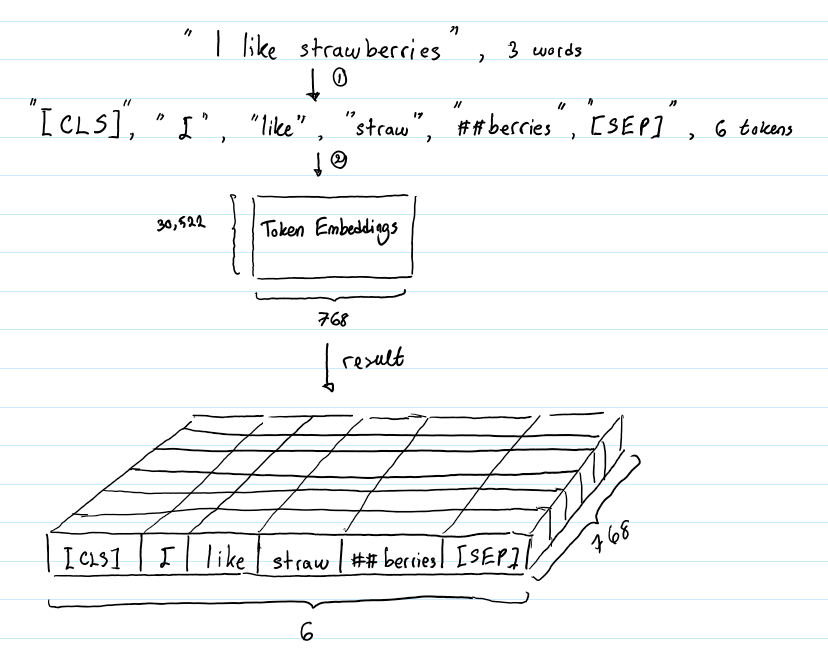

### Why was embedding size E fixed to hidden size  H anyway?

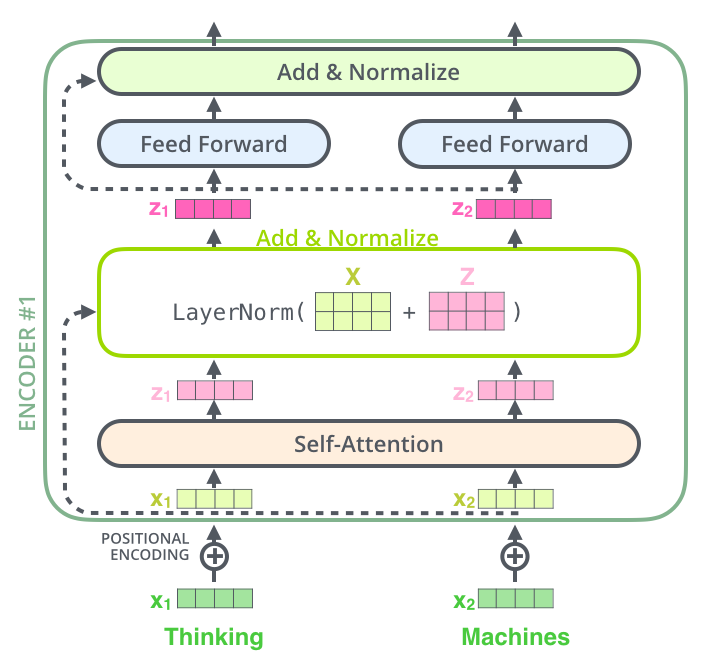

## 2) Cross-layer parameter sharing

#### --> apply same layer on top of each other 

## Squad Dataset

#### Excerpt:
Question: 'When did Beyonce start becoming popular?'<br>
Context: 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'<br>

Answer: 'in the late 1990s'<br>
Answer start and end position: [77, 81]

#### Stats:
130319 questions, contexts and answers<br>
130101 left after clipping maximum sequence length to 512<br>
86686 left after filtering questions with no answers

In [ ]:
from src.utils import get_dataset
PRETRAINED_PATH = 'huggingface/'
SQUAD_TRAIN_DATA_PATH = 'data/squad/train-v2.0.json'
train_dataset, input_tokens_train = get_dataset(SQUAD_TRAIN_DATA_PATH, PRETRAINED_PATH)

## Custom Classifier

In [ ]:
import tensorflow as tf
from transformers import TFAlbertModel, AlbertTokenizer
import numpy as np
import src.utils as u
class QaAlbertModel(tf.keras.Model):
    """Pretrained Albert Model with dense layer and QA head.
       Mostly following https://huggingface.co/transformers/model_doc/bert.html#tfbertforquestionanswering.
       Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
        **start_scores**: ``Numpy array`` or ``tf.Tensor`` of shape ``(batch_size, sequence_length,)``
            Span-start scores (before SoftMax).
        **end_scores**: ``Numpy array`` or ``tf.Tensor`` of shape ``(batch_size, sequence_length,)``
            Span-end scores (before SoftMax).
        **hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
            list of ``Numpy array`` or ``tf.Tensor`` (one for the output of each layer + the output of the embeddings)
            of shape ``(batch_size, sequence_length, hidden_size)``:
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        **attentions**: (`optional`, returned when ``config.output_attentions=True``)
            list of ``Numpy array`` or ``tf.Tensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads."""
    def __init__(self, config, *inputs, **kwargs):
        super(QaAlbertModel, self).__init__(config, *inputs, **kwargs)

        # config needs to be a dict
        self.linear_size = 128
        self.num_labels = config['num_labels']

        # set inputs to None (sequence length not known) as this is a condition for being able to save the model
        self.sequence = tf.keras.Input(shape=(None,), dtype=np.int32)

        self.albert = TFAlbertModel.from_pretrained('huggingface/')
        
        ## output dimension of [batch, bert_hidden_size, sequence_length]

        self.relu = tf.keras.layers.Activation('relu')

        # compute score of each output of a word t_i being the start or end of the answer:
        # s*t_i, e*t_j (s: start vector, e: end vector) in top layer with num_labels=2
        self.qa_linear = tf.keras.layers.Dense(
            self.linear_size, activation='relu',
            kernel_initializer=u.get_initializer(config['initializer_range']), name="qa_linear"
        )
        self.qa_outputs = tf.keras.layers.Dense(
            self.num_labels, kernel_initializer=u.get_initializer(config['initializer_range']), name="qa_outputs"
        )
        # sum over sequence
        self.softmax = tf.keras.layers.Softmax(axis=1)
        self.albert.trainable = False
        
        ## dimension of [batch, 2, sequence_length]

        # has to come at the end of this constructor, otherwise other layers are unknown
        self._set_inputs(self.sequence)

    def call(self, inputs, **kwargs):
        outputs = self.albert(inputs, **kwargs)

        sequence_output = self.relu(outputs[0])

        hidden_output = self.qa_linear(sequence_output)
        logits = self.qa_outputs(hidden_output)
        start_logits, end_logits = tf.split(logits, 2, axis=-1)
        start_logits = tf.squeeze(start_logits, axis=-1)
        end_logits = tf.squeeze(end_logits, axis=-1)

        start_output = self.softmax(start_logits)
        end_output = self.softmax(end_logits)

        # add hidden states and attention if they are here
        outputs = (tf.stack([start_output, end_output], axis=1),) + outputs[2:]


        return outputs  # start_logits, end_logits, (hidden_states), (attentions)

### Softmax over sequence length
$S$: "start vector"<br>
$T_i$: output vector for word i<br>
$P_i$: probability of word i being the start of answer interval

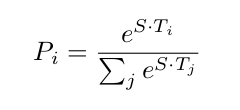

## Experiments

### Overfitting with Adam

Accuracy for:<br>learning rates: [1e-3, 5e-3, 1e-4, 1e-5], batch size: 32 <br>
fraction of dataset: 0.005, epochs: 200  --> no activations, dropout on

Accuracy for:<br>learning rates: [1e-3, 3e-3], batch size: 32<br>
fraction of dataset: 0.001, epochs: 200

### Raster search
Accuracy for:<br>learning rates: [1e-2, 1e-3, 3e-3, 5e-3, 7e-3, 1e-4, 5e-4], batch sizes: [16, 32, 64]<br>
fraction of dataset: 0.05, epochs: 8   --> best values with learning rates: [1e-3, 3e-3, 5e-3], smaller batch size better

### Serious training with Adam and LAMB
Accuracy and loss for:<br>learning rate: 1e-3, batch size: 16<br>
fraction of dataset: 0.2, epochs: 50<br>
optimizer: Adam<br>
training curve (pink) and validation curve (green)<br>
--> dropout too aggressive

Accuracy and loss for:<br>learning rate: 1.76e-3, batch size: 256<br>
fraction of dataset: 0.2, epochs: 50<br>
optimizer: LAMB<br>
training curve (grey) and validation curve (orange)

Accuracy and loss for:<br>learning rate: 1e-3, batch size: 16<br>
fraction of dataset: 0.2, epochs: 50<br>
optimizer: Adam<br>
no dropout<br>
training curve (blue) and validation curve (red)<br>

## Demo

In [ ]:
import json
with open(PRETRAINED_PATH + 'config.json') as f:
    config = json.load(f)
#%load_ext tensorboard
#%tensorboard --logdir logs/gradient_tape

In [ ]:
MODEL_SAVE_PATH = 'models/with_answers_only/'
model_weights_path = MODEL_SAVE_PATH + 'raster/lr0.001_batch1620200202-023815'

tokenizer = AlbertTokenizer.from_pretrained(PRETRAINED_PATH)
model = QaAlbertModel(config)
model.load_weights(model_weights_path + '/model')

In [ ]:
index = 3
for i, batch in enumerate(train_dataset.take(index + 1)):
    if i is index:
        inputs, labels = batch
inputs_pad = inputs[0]
token_type_ids = inputs[1]
labels = labels
preds = model(inputs=inputs_pad[None,:], token_type_ids=token_type_ids[None,:])
pos = tf.reshape(tf.math.argmax(preds, axis=3), [-1])
print(f'Input: {tokenizer.decode(inputs_pad)}\n'
      f'Label: {labels}\n'
      f'Correct Answer: {tokenizer.decode(inputs_pad[labels[0]:labels[1]+1])}\n'
      f'Max positions: {pos}\n'
      f'Predicted answer: {tokenizer.decode(inputs_pad[pos[0]:pos[1]+1])}')

## Git repo
https://github.com/andiwashere/question_answering

## Sources

https://arxiv.org/abs/1909.11942<br>
https://medium.com/@_init_/why-bert-has-3-embedding-layers-and-their-implementation-details-9c261108e28a<br>
https://jalammar.github.io/illustrated-transformer/<br>
https://ai.googleblog.com/2019/12/albert-lite-bert-for-self-supervised.html<br>
https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=2ahUKEwikiurh4rrnAhUGilwKHROdCmMQFjAAegQIAxAB&url=https%3A%2F%2Fweb.stanford.edu%2Fclass%2Fcs224n%2Freports%2Fdefault%2F15848021.pdf&usg=AOvVaw0QoKJp23CTHIrCnLpyEBkZ<br>